In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import os

from typing import List, Tuple, Any

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from scipy import stats
from math import sin, cos, sqrt, atan2, radians

%matplotlib inline

In [2]:
station_data = pd.read_csv('../data/Capital_Bike_Share_Locations.csv')
station_data.head(3)

,OBJECTID,ID,ADDRESS,TERMINAL_NUMBER,LATITUDE,LONGITUDE,INSTALLED,LOCKED,INSTALL_DATE,REMOVAL_DATE,TEMPORARY_INSTALL,NUMBER_OF_BIKES,NUMBER_OF_EMPTY_DOCKS,X,Y,SE_ANNO_CAD_DATA,OWNER
0,282368383,278,Monroe St & Monroe Pl,32017,39.083673,-77.149162,YES,NO,NaN,NaN,NO,7,8,387094.433149,157305.390735,NaN,NaN
1,282368384,279,Needwood Rd & Eagles Head Ct,32018,39.123513,-77.157410,YES,NO,NaN,NaN,NO,7,7,386388.439175,161729.331103,NaN,NaN
2,282368385,280,East West Hwy & Blair Mill Rd,32019,38.990249,-77.029350,YES,NO,NaN,NaN,NO,2,13,397457.288627,146924.157779,NaN,NaN


In [3]:
row_limit = 1000000
dataset = pd.DataFrame()
data_dir = '../data'
for file in os.listdir(data_dir):
    if file.startswith('2017'):
        tmp = pd.read_csv(os.path.join(data_dir, file), nrows=row_limit)
        dataset = pd.concat([dataset, tmp], sort=False, ignore_index=True)


print(f'Complete Dataset (rows, columns): {dataset.shape}')

dataset = dataset.loc[(dataset['Duration'] <= (60 * 60 * 1.5)), :]
print(f'Complete Dataset (rows, columns): {dataset.shape} (REMOVING OUTLIERS)')


testset = dataset.sample(frac=0.33, random_state=33)
dataset.drop(testset.index, inplace=True)
print(f'Trainset (rows, columns): {dataset.shape}')
print(f'Testset (rows, columns): {testset.shape}')
dataset.head(3)

Complete Dataset (rows, columns): (1000000, 9)
Complete Dataset (rows, columns): (968232, 9) (REMOVING OUTLIERS)
Trainset (rows, columns): (648715, 9)
Testset (rows, columns): (319517, 9)


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,381,2017-04-01 00:00:22,2017-04-01 00:06:43,31238,14th & G St NW,31202,14th & R St NW,W22257,Member
2,2938,2017-04-01 00:02:32,2017-04-01 00:51:30,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31238,14th & G St NW,W22225,Casual
3,380,2017-04-01 00:03:02,2017-04-01 00:09:23,31121,Calvert St & Woodley Pl NW,31104,Adams Mill & Columbia Rd NW,W20146,Member


In [4]:
# dataset = dataset.loc[(dataset['Duration'] <= (60 * 60 * 3)) & (dataset['Duration'] >= (60 * 3)), :]

In [5]:
dataset['duration-log1p'] = np.log1p(dataset['Duration'])

In [6]:
class PrepareRiders(BaseEstimator, TransformerMixin):
    
    def __init__(self, use_columns: list, station_median_dict: dict, station_stats_dict: dict):
        self.use_columns = use_columns
        self.station_median_dict = station_median_dict
        self.station_stats_dict = station_stats_dict
        self._final_columns = None
        
    def _station_median_duration(self, station_num: int) -> float:
        return self.station_median_dict.get(station_num, 0)
    
    def _get_nearest_station_dist(self, station_num: int) -> float:
        nearest = self.station_stats_dict.get(station_num)
        if not nearest:
#             print(f'no nearest? : {station_num}')
            nearest = 0
        else:
            nearest = nearest[0]
        return nearest
    
    def _get_average_dist_from_stations(self, station_num: int) -> float:
        average = self.station_stats_dict.get(station_num)
        if not average:
#             print(f'no average? : {station_num}')
            average = 0
        else:
            average = average[1]
        return average
    
    def _make_time_cyclical(self, feature: pd.Series, time_divisor: int) -> Tuple[np.array, np.array]:
        sin = np.sin(2 * np.pi * feature / time_divisor)
        cos = np.cos(2 * np.pi * feature / time_divisor)
        return (sin, cos)
        
    def transform(self, Xt: pd.DataFrame) -> np.array:
        # only use specified columns
        Xt = Xt.loc[:, self.use_columns]
        print(f'Initial dataset shape: {Xt.shape}')
        
        # convert to date type
        Xt['start-date-ts'] = pd.to_datetime(Xt['Start date'])
        
        # separate out date features
        Xt['day_of_week'] = Xt['start-date-ts'].apply(lambda x: x.dayofweek)
        Xt['week_of_year'] = Xt['start-date-ts'].apply(lambda x: x.weekofyear)
        Xt['month'] = Xt['start-date-ts'].apply(lambda x: x.month)
        Xt['minute'] = Xt['start-date-ts'].apply(lambda x: x.minute)
        Xt['hour'] = Xt['start-date-ts'].apply(lambda x: x.hour)
        Xt.drop(['Start date', 'start-date-ts'], axis=1, inplace=True)
        
        # make date features cyclical
        Xt['sin_day_of_week'], Xt['cos_day_of_week'] = self._make_time_cyclical(Xt['day_of_week'], 7)
        Xt['sin_week_of_year'], Xt['cos_week_of_year'] = self._make_time_cyclical(Xt['week_of_year'], 53)
        Xt['sin_month'], Xt['cos_month'] = self._make_time_cyclical(Xt['month']-1, 12)
        Xt['sin_minute'], Xt['cos_minute'] = self._make_time_cyclical(Xt['minute'], 60)
        Xt['sin_hour'], Xt['cos_hour'] = self._make_time_cyclical(Xt['hour'], 24)
        Xt.drop(['day_of_week', 'week_of_year', 'month', 'minute', 'hour'], axis=1, inplace=True)
        
        # custom transformations
#         Xt['station_median'] = Xt['Start station number'].apply(lambda x: self._station_median_duration(x))    
#         Xt['nearest_station'] = Xt['Start station number'].apply(lambda x: self._get_nearest_station_dist(x))
#         Xt['average_distance'] = Xt['Start station number'].apply(lambda x: self._get_average_dist_from_stations(x))
        Xt.drop(['Start station number'], axis=1, inplace=True)
        
        # transform categorical features
#         Xt['start-station-num'] = Xt['Start station number'].astype(str)
#         Xt.drop(['Start station number'], axis=1, inplace=True)
        Xt = pd.get_dummies(Xt)
        
        # save final columns
        if not self._final_columns:
            self._final_columns = Xt.columns.tolist()
            print(f'Final Columns: {self._final_columns}')
        else:
            not_in_training = list(set(Xt.columns.tolist()) - set(self._final_columns))
            not_in_testing = list(set(self._final_columns) - set(Xt.columns.tolist()))
            if not_in_training:
                Xt.drop(not_in_training, axis=1, inplace=True)
            if not_in_testing:
                empties = dict.fromkeys(not_in_testing, 0)
                Xt = Xt.assign(**empties)
        print(f'Prepared dataset shape: {Xt.shape}')
        return Xt.values
    
    def fit(self, X, y=None, **kwargs):
        return self

In [7]:
def rmse_func(y_true: np.array, y_pred: np.array) -> float:
    return mean_squared_error(y_true, y_pred) ** 0.5

rmse_scorer = make_scorer(rmse_func, greater_is_better=False)

def scoresReport(y_true: np.array, y_pred: np.array) -> None:
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = rmse_func(y_true, y_pred)
    print(f'Scores Report:\nR2: {r2}\nMSE: {mse}\nRMSE: {rmse}\n')
    return

# plot the residuals
def fourPlot(y_true: np.array, y_pred: np.array) -> None:
    plt.figure(figsize=(12,8));
    residuals = y_true - y_pred
    # Histogram
    plt.subplot(2,2,1);
    plt.title("Histogram");
    plt.hist(residuals, alpha=0.5);
    # Lag plot
    plt.subplot(2,2,2);
    plt.title("Lag Plot");
    lag = residuals.copy()
    lag = lag[:-1]
    current = residuals[1:]
    sns.regplot(current, lag, fit_reg=False);
    # QQ plot
    plt.subplot(2,2,3);
    plt.title("QQ Plot");
    qntls, xr = stats.probplot(residuals, fit=False)
    sns.regplot(xr, qntls, ci=0);
    # Run Sequence plot
    plt.subplot(2,2,4);
    plt.title("Run Sequence");
    sns.regplot(np.arange(len(residuals)), residuals, ci=0);
    return

In [8]:
def run_gridsearch_with_pipe(
        regressors: list, 
        params_map: dict, 
        cv: KFold,
        x1: pd.DataFrame, 
        x2: pd.DataFrame, 
        y1: np.array, 
        y2: np.array
) -> None:
        
    for reg, model in regressors:
        params = params_map[reg]
        pipe = Pipeline(
            steps=[
                (
                    'prepare', 
                    PrepareRiders(
                        use_columns=use_columns, 
                        station_median_dict=station_medians,
                        station_stats_dict=station_stats
                    )
                ),
                (
                    'scaler',
                    StandardScaler()
                ),
                (
                    reg, 
                    model(random_state=33)
                )
            ]
        )
        grid = GridSearchCV(estimator=pipe, param_grid=params, scoring=rmse_scorer, cv=kf, n_jobs=2)
        grid.fit(x1, y1)
        print(f'Best Params:\n{grid.best_params_}')
        best_est = grid.best_estimator_.named_steps[reg]
#         prep = grid.best_estimator_.named_steps['prepare']
        # top_features = pd.Series(est.feature_importances_, index=prep._final_columns).sort_values(ascending=False).head(10)
        test_preds = grid.predict(x2)
        testset_raw_score = np.sqrt(mean_squared_error(y2, test_preds))
        testset_rmse_expm1 = np.sqrt(mean_squared_error(np.expm1(y2), np.expm1(test_preds)))
        context_error = f'This model is off by ~{round(testset_rmse_expm1 / 60, 2)} minutes'
#         print(f'Model: {reg}\nRMSE: {testset_raw_score}\nRMSE EXPM1: {testset_rmse_expm1}\nCONTEXT: {context_error}\nPARAMS: {grid.best_params_}')
        # check residuals with the "Four Plot"
        scoresReport(y2, test_preds)
        print(f'Context error: {context_error}')
        fourPlot(y2, test_preds)

In [9]:
def get_distance(s1: Tuple[float, float], s2: Tuple[float, float]) -> float:
    R = 6373.0
    lat1 = radians(s1[0])
    lat2 = radians(s2[0])
    lon1 = radians(s1[1])
    lon2 = radians(s2[1])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

def get_nearest_station_dist(station_num) -> Tuple[float, float]:
    station_coords = station_coords_dict.get(station_num)
    if not station_coords:
        print(f'Never seen station: {station_num}')
        return (0.0, 0.0)
    distances_list = []
    for station_lookup_num, coords in station_coords_dict.items():
        if station_lookup_num != station_num:
            distance = get_distance(coords, station_coords)
            dist_info = (station_lookup_num, distance)
            distances_list.append(dist_info)
    nearest = sorted(distances_list, key = lambda x: x[1])[0][1]
    average = sum(map(lambda x: x[1], distances_list)) / len(distances_list)
    return nearest, average

In [10]:
coords = station_data.groupby('TERMINAL_NUMBER').agg({'LONGITUDE': 'unique', 'LATITUDE': 'unique'})
station_coords_dict = {}
for station_num, long_lat_series in coords.iterrows():
    long, lat = long_lat_series.values
    station_coords_dict[int(station_num)] = (lat[0], long[0])

station_stats = {}
for station_num, lat_and_long in station_coords_dict.items():
    n, a = get_nearest_station_dist(station_num)
    station_stats[station_num] = (n, a)

In [11]:
# station_stats
# missing: 31008 32034 32051

In [12]:
# create training and testing inputs and target features
x1, y1 = dataset.iloc[:,1:], dataset['duration-log1p'].values
x2, y2 = testset.iloc[:,1:], np.log1p(testset['Duration']).values

# create input parameters to PrepareRiders
use_columns = ['Start date', 'Member type', 'Start station number']
station_medians = dataset.groupby('Start station number').agg(
    {'Duration': ['median']}).to_dict()[('Duration', 'median')]

Initial dataset shape: (648715, 3)
Final Columns: ['sin_day_of_week', 'cos_day_of_week', 'sin_week_of_year', 'cos_week_of_year', 'sin_month', 'cos_month', 'sin_minute', 'cos_minute', 'sin_hour', 'cos_hour', 'station_median', 'nearest_station', 'average_distance', 'Member type_Casual', 'Member type_Member']
Prepared dataset shape: (648715, 15)
Best Params:
{'rd__alpha': 1.0, 'rd__max_iter': None}
Initial dataset shape: (319517, 3)
Prepared dataset shape: (319517, 15)
Scores Report:
R2: 0.2893639756712002
MSE: 0.4295696068564192
RMSE: 0.655415598575758

Context error: This model is off by ~12.62 minutes


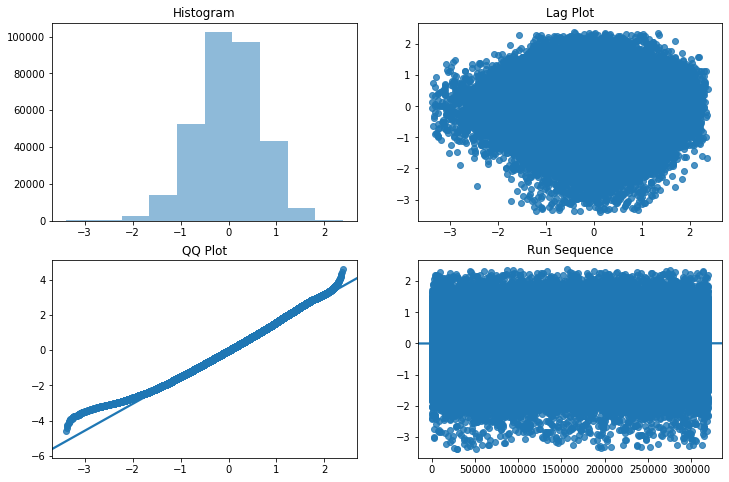

In [13]:
params_map = {
#     'rf': {
#         'rf__max_depth': [5],
#         'rf__n_estimators': [150],
#         'rf__min_samples_split': [2],
#         'rf__min_samples_leaf': [1],
#         'rf__min_weight_fraction_leaf': [0.0],
#     },
#     'gb': {
#         'gb__max_depth': [3, 5],
#         'gb__n_estimators': [100, 150],
#         'gb__learning_rate': [0.1],
#     },
#     'ls': {
#         'ls__alpha': [1.0, 0.5, 0.1],
#         'ls__max_iter': [1000, 1500]
#     },
    'rd': {
        'rd__alpha': [1.0],
        'rd__max_iter': [None]
    }
}

regressors = [
#     ('rf', RandomForestRegressor),
#     ('gb', GradientBoostingRegressor),
#     ('ls', Lasso),
    ('rd', Ridge)
]

kf = KFold(n_splits=7, shuffle=True, random_state=33)

run_gridsearch_with_pipe(
    regressors=regressors, 
    params_map=params_map,
    cv=kf,
    x1=x1,
    x2=x2,
    y1=y1,
    y2=y2
)